# Neural style transfer - BIU deep learning final project

as learned from https://keras.io/examples/generative/neural_style_transfer/

# setting - imports and files

In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg19

In [ ]:
import gdown
url = "https://drive.google.com/drive/u/1/folders/1zbdIvBHk9Yrkf46vLe9PhoWK-amV2a8F"
gdown.download_folder(url, quiet=True)

['/content/monet-30/0a5075d42a.jpg',
 '/content/monet-30/4b0adf7c6f.jpg',
 '/content/monet-30/4c74254ad3.jpg',
 '/content/monet-30/4f4de0bbba.jpg',
 '/content/monet-30/6bbe0e63c6.jpg',
 '/content/monet-30/6d0e87f557.jpg',
 '/content/monet-30/11be65b3e9.jpg',
 '/content/monet-30/51bdd25f76.jpg',
 '/content/monet-30/89d970411d.jpg',
 '/content/monet-30/89fcbf2f76.jpg',
 '/content/monet-30/95a53d7b0b.jpg',
 '/content/monet-30/4260d1c556.jpg',
 '/content/monet-30/7017e6caa1.jpg',
 '/content/monet-30/910610e827.jpg',
 '/content/monet-30/4660310c3e.jpg',
 '/content/monet-30/a06b54dfe9.jpg',
 '/content/monet-30/b5c2fe7c4c.jpg',
 '/content/monet-30/b76d52e05a.jpg',
 '/content/monet-30/bf6db09354.jpg',
 '/content/monet-30/d9e8704878.jpg',
 '/content/monet-30/d729785cb8.jpg',
 '/content/monet-30/d4116437bb.jpg',
 '/content/monet-30/dcab49d080.jpg',
 '/content/monet-30/dcf5ea1040.jpg',
 '/content/monet-30/dd46691bd7.jpg',
 '/content/monet-30/e291f8144f.jpg',
 '/content/monet-30/eb3cc5c559.jpg',
 

# make the neural style transfer

In [ ]:
import os
monetCollection = []
for (dirpath, dirnames, filenames) in os.walk("monet-30"):
    monetCollection.extend(filenames)
    break

we defined preprocessing and deprocessing functions

In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

defining loss functions - for the style, content, and the combination

In [ ]:
img_nrows = 320
img_ncols = int(256 * img_nrows / 256)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))
  
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

for this experiment we used VGG19 pre trained model

In [ ]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"

total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    # can be input tensor of [base img, [...style imgs]*30, combi]
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    # combi feature of the last
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        # for each layer we compute loss for the 30 styles
        layer_features = features[layer_name]
        #      put in for loop for each style from this: (replace 1 in the index)
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
        #      to this

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.99
    )
)

Experiment one - choose only 1 style image from the monet directory. we choose it by histogram compartion

In [ ]:
def generate_specific_style(base_image_path, style_reference_image_path, iterations, result_name):
  base_image = preprocess_image(base_image_path)
  combination_image = tf.Variable(preprocess_image(base_image_path))
  losses = []
  for i in range(1, iterations + 1):
      style_reference_image = preprocess_image(style_reference_image_path)
      loss, grads = compute_loss_and_grads(
          combination_image, base_image, style_reference_image
      )
      optimizer.apply_gradients([(grads, combination_image)]) 
      losses.append(float(loss))
      print("epoch no.",i,", the loss is", float(loss))  
  img = deprocess_image(combination_image.numpy())
  return losses, img

In [ ]:
def histogram_compare(image1, image2):
  hist1_red, _ = np.histogram(image1[:,:,0], bins=256, range=(0, 255))
  hist1_green, _ = np.histogram(image1[:,:,1], bins=256, range=(0, 255))
  hist1_blue, _ = np.histogram(image1[:,:,2], bins=256, range=(0, 255))

  hist2_red, _ = np.histogram(image2[:,:,0], bins=256, range=(0, 255))
  hist2_green, _ = np.histogram(image2[:,:,1], bins=256, range=(0, 255))
  hist2_blue, _ = np.histogram(image2[:,:,2], bins=256, range=(0, 255))

  # Concatenate the histograms for each color channel into a single feature vector for each image
  hist1 = np.concatenate([hist1_red, hist1_green, hist1_blue])
  hist2 = np.concatenate([hist2_red, hist2_green, hist2_blue])

  # Compute the chi-squared distance between the two histograms
  d = np.sum((hist1 - hist2)**2 / (hist1 + hist2 + 1e-10)) / 2.0
  return d

In [ ]:
def picking_style(photo_path):
  photo1 = preprocess_image(photo_path)
  mina = float('inf')
  style_choose = ''
  for style in monetCollection:
    monet = preprocess_image("/content/monet-30/"+style)
    tis = histogram_compare(monet,photo1)
    if tis < mina:
      mina = tis
      style_choose = style
  return "/content/monet-30/"+style_choose


Experiment Two - using all the 30 images, each one in another step. for this we multiply the number of steps in 30

In [ ]:
def generate_wholistic_style(base_image_path, style_reference_image_path, iterations, result_name):
  base_image = preprocess_image(base_image_path)
  combination_image = tf.Variable(preprocess_image(base_image_path))
  losses = []
  average_loss = []
  for i in range(1, iterations*30 + 1):
      style_reference_image = preprocess_image(style_reference_image_path[i%30])
      loss, grads = compute_loss_and_grads(
          combination_image, base_image, style_reference_image
      )
      optimizer.apply_gradients([(grads, combination_image)]) 
      average_loss.append(float(loss))
      if (i % 30)==0:
        avg_loss = sum(average_loss)/30
        losses.append(avg_loss)
        print("epoch no.",i,", the loss is", avg_loss) 
        average_loss = [] 
  img = deprocess_image(combination_image.numpy())
  return losses, img

## testing the model:

for single style image - upload onlly singke image!

In [ ]:
from google.colab import files
picture = files.upload()


Saving fdf57fbe60.jpg to fdf57fbe60.jpg


In [ ]:
picture_path = list(picture.keys())[0]

In [ ]:
_,stylized = generate_specific_style(picture_path, picking_style(picture_path),150,picture_path)

epoch no. 1 , the loss is 15835.029296875


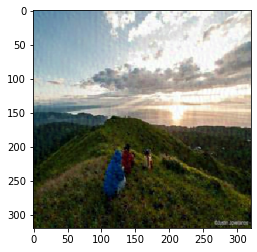

In [ ]:
plt.imshow(stylized)